In [384]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from numpy.version import full_version
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

In [385]:
img_path = "/Users/fathe/OneDrive/Documents/UK/MFF/Thesis/output/GX010010_preprocessed-oio-0.png"

[ 7454  8636 10612 ... 12001 11883 11767]
(1300, 100)


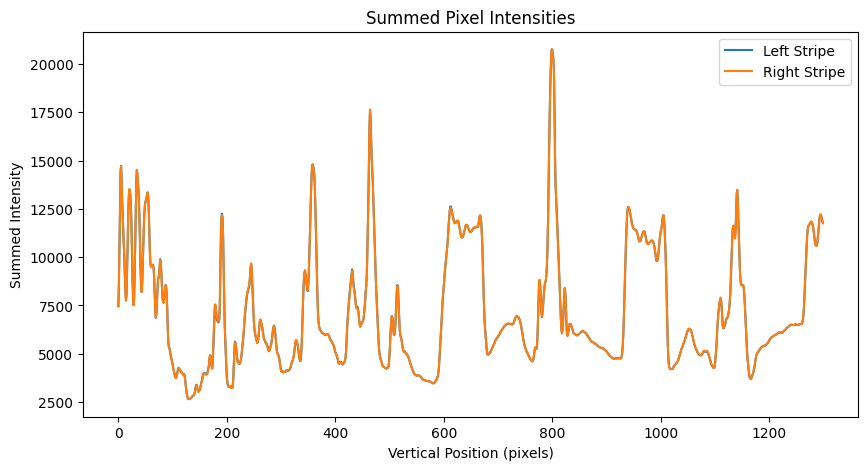

In [414]:
# Load the image
image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Define the width of the stripe
stripe_width = 100
shift = 1

# Extract vertical stripes
left_stripe = image[:, 10156:10156+stripe_width]
print(np.sum(left_stripe, axis=1))
right_stripe = image[:, 10156+shift:10156+stripe_width+shift]
print(right_stripe.shape)

# Sum pixel intensities along the x-axis
left_sum = np.sum(left_stripe, axis=1)
right_sum = np.sum(right_stripe, axis=1)

# left_sum = gaussian_filter1d(left_sum, sigma=23)
# right_sum = gaussian_filter1d(right_sum, sigma=23)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(left_sum, label="Left Stripe")
plt.plot(right_sum, label="Right Stripe")
plt.title("Summed Pixel Intensities")
plt.xlabel("Vertical Position (pixels)")
plt.ylabel("Summed Intensity")
plt.legend()
plt.show()

In [415]:
distance = 100
# Detect peaks
peaks_left, _ = find_peaks(left_sum, distance=distance)
peaks_right, _ = find_peaks(right_sum, distance=distance)

# Display detected peaks
print("Peaks in left stripe:", peaks_left)
print("Peaks in right stripe:", peaks_right)

np.mean(peaks_left - peaks_right)

Peaks in left stripe: [   5  191  358  464  613  799  940 1141 1295]
Peaks in right stripe: [   5  191  358  464  613  799  940 1141 1295]


np.float64(0.0)

In [388]:
image.shape[0]//2

650

In [416]:
# Load the image
image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
image = image[image.shape[0]//2:, :]

# Define the width of the stripe
stripe_width = 100
shift = 10
movements = []

for i in range(0, image.shape[1]-stripe_width, shift):
    # Extract vertical stripes
    left_stripe = image[:, i:stripe_width+i]
    right_stripe = image[:, i+shift:stripe_width+i+shift]
    
    # Sum pixel intensities along the x-axis
    left_sum = np.sum(left_stripe, axis=1)
    right_sum = np.sum(right_stripe, axis=1)
    
    left_sum = gaussian_filter1d(left_sum, sigma=23)
    right_sum = gaussian_filter1d(right_sum, sigma=23)
    
    distance = 150
    # Detect peaks
    peaks_left, _ = find_peaks(left_sum, distance=distance)
    peaks_right, _ = find_peaks(right_sum, distance=distance)
    
    try:
        if peaks_left.shape[0] > peaks_right.shape[0]:
            movement1 = np.mean(peaks_left[1:] - peaks_right)
            movement2 = np.mean(peaks_left[:-1] - peaks_right)
            if abs(movement1) > abs(movement2):
                movement = movement2
            else:
                movement = movement1
            
        elif peaks_left.shape[0] < peaks_right.shape[0]:
            movement1 = np.mean(peaks_left - peaks_right[:-1])
            movement2 = np.mean(peaks_left - peaks_right[1:])
            if abs(movement1) > abs(movement2):
                movement = movement2
            else:
                movement = movement1
        else: 
            movement = np.mean(peaks_left - peaks_right)
            
        if abs(movement) > 5 or movement is None:
            movement = movements[-1]
        movements.append(movement)
    except:
        # Plot the results
        plt.figure(figsize=(10, 5))
        plt.plot(left_sum, label="Left Stripe")
        plt.plot(right_sum, label="Right Stripe")
        plt.title("Summed Pixel Intensities")
        plt.xlabel("Vertical Position (pixels)")
        plt.ylabel("Summed Intensity")
        plt.legend()
        plt.show()
        
        # Display detected peaks
        print("Peaks in left stripe:", peaks_left)
        print("Peaks in right stripe:", peaks_right)
        break

In [417]:
len(movements), image.shape[1], max(movements)

(1107, 11161, np.float64(2.25))

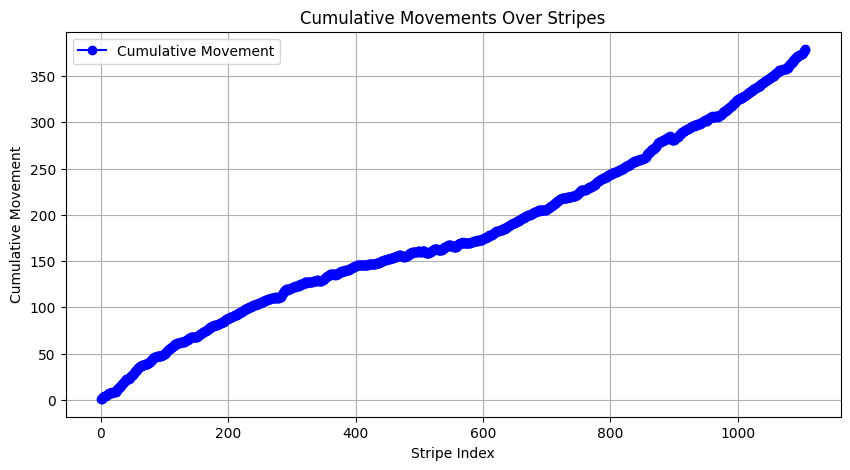

In [418]:
cumulative_movements = np.cumsum(movements)
    
# Plot cumulative movements
plt.figure(figsize=(10, 5))
plt.plot(cumulative_movements, marker='o', linestyle='-', color='blue', label="Cumulative Movement")
plt.title("Cumulative Movements Over Stripes")
plt.xlabel("Stripe Index")
plt.ylabel("Cumulative Movement")
plt.legend()
plt.grid(True)
plt.show()

In [419]:
# Generate x-values corresponding to movement indices
x = np.arange(len(cumulative_movements))

# Linear regression to remove rotation
coefficients = np.polyfit(x, cumulative_movements, deg=1)
linear_trend = np.polyval(coefficients, x)

In [420]:
detrended_movements = cumulative_movements - linear_trend

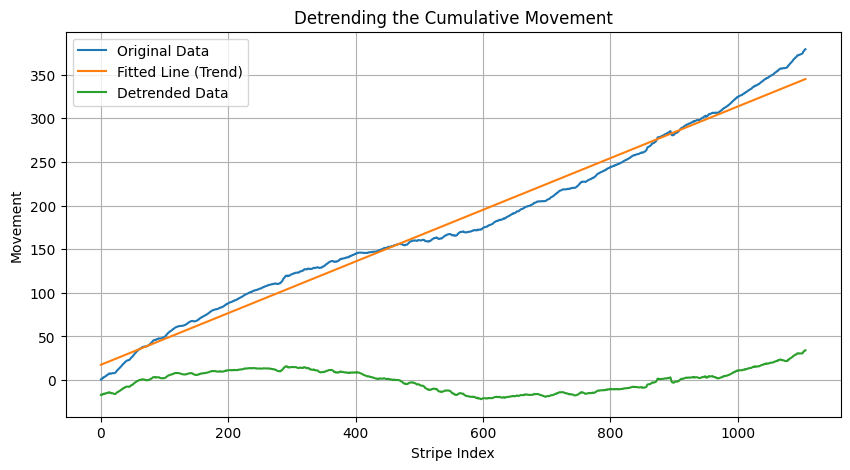

In [421]:
# Plot to visualize detrending
plt.figure(figsize=(10, 5))
plt.plot(x, cumulative_movements, label="Original Data")
plt.plot(x, linear_trend, label="Fitted Line (Trend)")
plt.plot(x, detrended_movements, label="Detrended Data")
plt.legend()
plt.xlabel("Stripe Index")
plt.ylabel("Movement")
plt.title("Detrending the Cumulative Movement")
plt.grid(True)
plt.show()

In [395]:
# Define the sinusoidal model
def sinusoid(x, A, B, C, D):
    return A * np.sin(B * x + C) + D

def rotated_sinusoid(x, A, B, C, D, theta):
    y = A * np.sin(B * x + C) + D
    # Rotate the sinusoid using the angle theta
    x_rot = x * np.cos(theta) - y * np.sin(theta)
    y_rot = x * np.sin(theta) + y * np.cos(theta)
    return y_rot

In [396]:
slope = coefficients[0]
theta_initial = np.arctan(slope)

In [397]:
theta_initial

np.float64(0.28774091033639787)

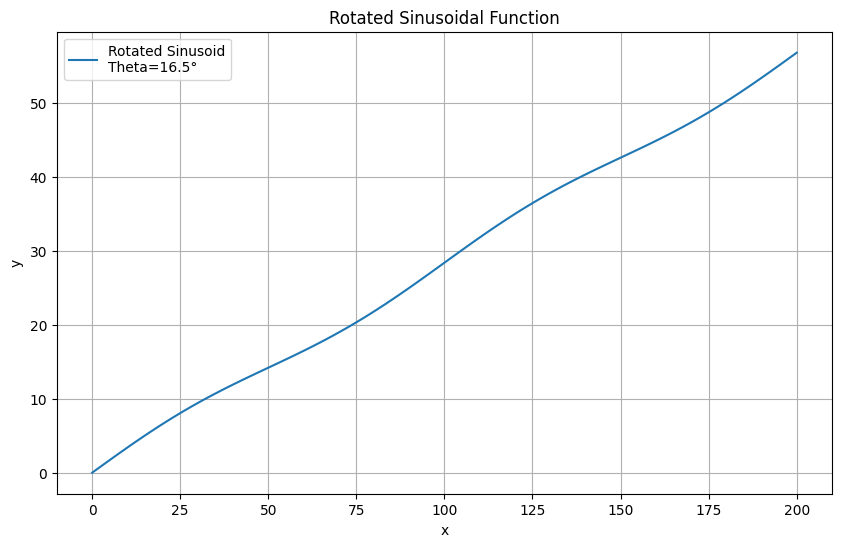

In [398]:
# Test parameters
A = 1       # Amplitude
B = 2 * np.pi / 100  # Frequency (a full wave in 100 points)
C = 0       # Phase shift
D = 0       # Vertical shift
theta = theta_initial  # Rotation angle (30 degrees)

# Create x values
x = np.linspace(0, 200, 100)

# Generate the data based on the parameters
y = rotated_sinusoid(x, A, B, C, D, theta)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x, y, label=f'Rotated Sinusoid\nTheta={np.degrees(theta):.1f}°')
plt.title('Rotated Sinusoidal Function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

[np.float64(34.162317089476346), 0.005675867486160421, 0, 0, np.float64(-4.7247721991646194e-17)]
Amplitude: 19.800146267021642, Frequency: 0.006829195086133393, Phase: -0.10139725813605338, Vertical Shift: -10.312489845130681, Rotation (theta): 0.01577621833225682


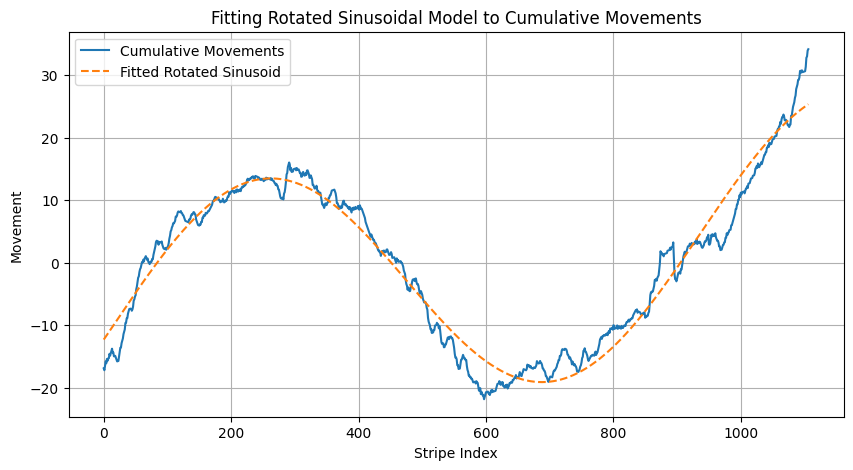

In [399]:
# Example: X and Cumulative Movements (you can replace this with your actual data)
x = np.arange(len(detrended_movements))

# Linear regression to remove rotation
coefficients = np.polyfit(x, detrended_movements, deg=1)
linear_trend = np.polyval(coefficients, x)

# Linear regression to remove rotation (get initial guess for rotation)
coefficients = np.polyfit(x, detrended_movements, deg=1)

# Estimate rotation angle from the slope of the line
slope = coefficients[0]
theta_initial = np.arctan(slope)

# Initial guess for parameters: [Amplitude, Frequency, Phase, Vertical shift, Rotation]
initial_guesses = [np.max(detrended_movements), 2 * np.pi / len(detrended_movements), 0, 0, theta_initial]
print(initial_guesses)

lower_bounds = [0, 2*np.pi/len(detrended_movements), -np.pi, -np.inf, -np.inf]  # Set lower bounds
upper_bounds = [np.inf, 2*np.pi, np.pi, np.inf, np.inf]  # Set upper bounds

# Fit the model
params, _ = curve_fit(rotated_sinusoid, x, detrended_movements, p0=initial_guesses, bounds=(lower_bounds, upper_bounds), method='trf', maxfev=5000)

# Extract fitted parameters
A, B, C, D, theta = params
print(f"Amplitude: {A}, Frequency: {B}, Phase: {C}, Vertical Shift: {D}, Rotation (theta): {theta}")

# Generate fitted rotated sinusoid
fitted_rotated_sinusoid = rotated_sinusoid(x, *params)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(x, detrended_movements, label="Cumulative Movements")
plt.plot(x, fitted_rotated_sinusoid, label="Fitted Rotated Sinusoid", linestyle="--")
plt.legend()
plt.xlabel("Stripe Index")
plt.ylabel("Movement")
plt.title("Fitting Rotated Sinusoidal Model to Cumulative Movements")
plt.grid(True)
plt.show()

In [400]:
np.roll([1,2,3], -1)

array([2, 3, 1])

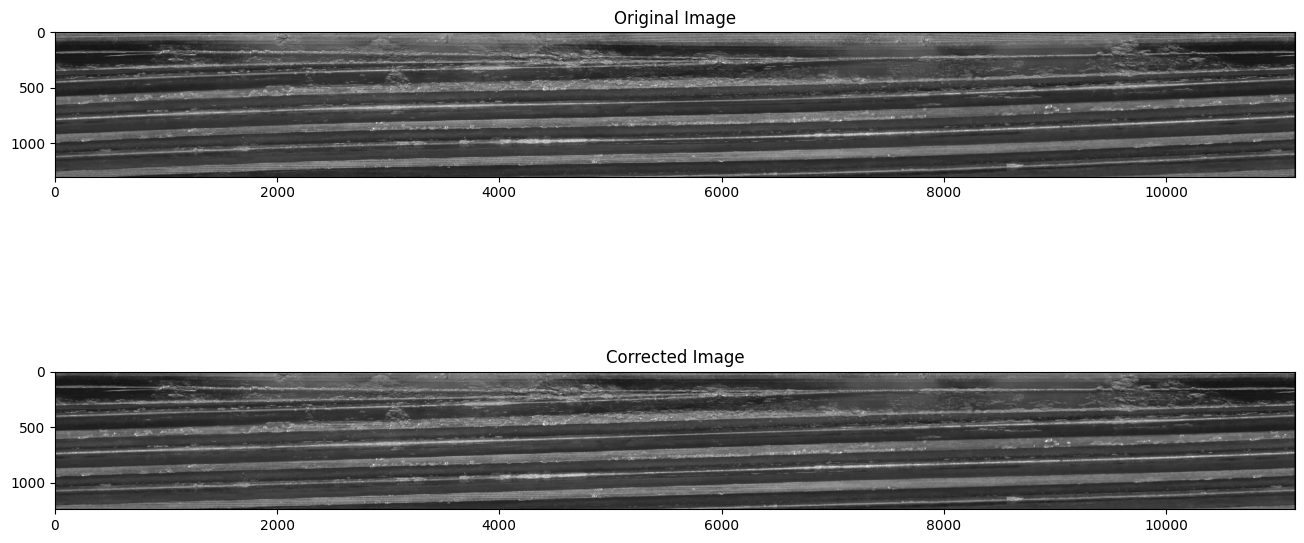

In [403]:
# Define function to remove sinusoidal distortion (column-wise)
def remove_sinusoidal_transformation(image, params):
    A, B, C, D, theta = params
    
    # Create an empty output image
    output_image = np.zeros_like(image)
    
    # Track the maximum shift
    max_shift = 0
    
    # Loop over each column
    for j in range(image.shape[1]):
        # Calculate the vertical shift for this column based on the sinusoidal function
        shift = sinusoid(j, A, B/10, C, D)
        max_shift = max(max_shift, abs(shift))  # Update maximum shift
        
        # Shift the whole column
        # Use np.roll to shift the column by the calculated value
        new_column = np.roll(image[:, j], int(shift))
        
        # Assign the shifted column back to the output image
        output_image[:, j] = new_column
    
    # Crop the image to remove the wrapped-around pixels
    if max_shift > 0:
        output_image = output_image[int(max_shift): -int(max_shift), :]
    
    return output_image

image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
# Apply the removal
output_image = remove_sinusoidal_transformation(image, params)

# Display the original and corrected image
plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
plt.title("Original Image")
plt.imshow(image, cmap="gray")
plt.subplot(2, 1, 2)
plt.title("Corrected Image")
plt.imshow(output_image, cmap="gray")
plt.show()
